# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('previsao_de_renda.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.
8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é a mesma que a previsão média do log(renda).
9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.
10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico. Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.


# 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

In [30]:
from sklearn.model_selection import train_test_split

# Defina as features (X) e o alvo (y)
features = df.drop(['Unnamed: 0', 'data_ref', 'id_cliente', 'idade', 'sexo', 'estado_civil', 'tipo_residencia' ], axis=1)  # Remove as colunas desnecessárias
target = df['renda']

# Separe a base em treinamento e teste (75% para treinamento, 25% para teste)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Exiba o tamanho dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))


Tamanho do conjunto de treinamento: 11250
Tamanho do conjunto de teste: 3750


In [31]:
# Exiba as colunas do conjunto de features do modelo treinado
print("Colunas do conjunto de features:")
print(X_train.columns)


Colunas do conjunto de features:
Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
       'educacao', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
      dtype='object')


# 2. Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  𝑅2  na base de testes. Qual o melhor modelo?

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Valores de alpha que você deseja testar
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Colunas categóricas e numéricas
colunas_categoricas = ['posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',]
colunas_numericas = ['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia']

# Crie um transformador para aplicar a codificação one-hot nas colunas categóricas
# e preencher valores faltantes nas colunas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), colunas_categoricas),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), colunas_numericas)
    ],
    remainder='passthrough'  # mantém as colunas não especificadas
)

# Inicialize um dicionário para armazenar os modelos e os erros
modelos_ridge = {}
erros_rmse = {}

# Supondo que você já tenha os conjuntos de treinamento e teste (X_train, X_test, y_train, y_test)

# Treine os modelos Ridge para diferentes valores de alpha
for alpha in alphas:
    # Inicialize o modelo Ridge dentro do pipeline
    modelo_ridge = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge(alpha=alpha))
    ])

    # Trate valores faltantes e treine o modelo
    modelo_ridge.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    previsoes = modelo_ridge.predict(X_test)

    # Calcule o erro RMSE
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))

    # Armazene o modelo e o erro RMSE
    modelos_ridge[alpha] = modelo_ridge
    erros_rmse[alpha] = rmse

# Exiba os erros RMSE para diferentes valores de alpha
for alpha, rmse_valor in erros_rmse.items():
    print(f'Alpha: {alpha}, RMSE: {rmse_valor}')



Alpha: 0, RMSE: 5.419680126610001e-11
Alpha: 0.001, RMSE: 8.085438553014125e-11
Alpha: 0.005, RMSE: 1.272363747123943e-10
Alpha: 0.01, RMSE: 1.8360448695860677e-10
Alpha: 0.05, RMSE: 6.510958757097881e-10
Alpha: 0.1, RMSE: 1.2329432465650178e-09


In [33]:
from sklearn.metrics import r2_score

# Inicialize um dicionário para armazenar os valores de R2
r2_valores = {}

# Avalie o R2 para diferentes valores de alpha
for alpha, modelo_ridge in modelos_ridge.items():
    # Faça previsões no conjunto de teste
    previsoes = modelo_ridge.predict(X_test)

    # Calcule o R2
    r2 = r2_score(y_test, previsoes)

    # Armazene o valor de R2
    r2_valores[alpha] = r2

# Exiba os valores de R2 para diferentes valores de alpha
for alpha, r2_valor in r2_valores.items():
    print(f'Alpha: {alpha}, R2: {r2_valor}')


Alpha: 0, R2: 1.0
Alpha: 0.001, R2: 1.0
Alpha: 0.005, R2: 1.0
Alpha: 0.01, R2: 1.0
Alpha: 0.05, R2: 1.0
Alpha: 0.1, R2: 1.0


In [34]:
# Imprima os resultados para análise
for alpha, r2_valor in r2_valores.items():
    print(f'Alpha: {alpha}, R2: {r2_valor}')

# Encontre o melhor modelo com base no R2
melhor_alpha = max(r2_valores, key=r2_valores.get)
melhor_modelo = modelos_ridge[melhor_alpha]

print(f'\nMelhor modelo:')
print(f'Melhor Alpha: {melhor_alpha}')
print(f'R2 do Melhor Modelo: {r2_valores[melhor_alpha]}')

# Se desejar, você pode explorar os coeficientes do melhor modelo
coeficientes = melhor_modelo.named_steps['ridge'].coef_
print('\nCoeficientes do Melhor Modelo:')
print(coeficientes)


Alpha: 0, R2: 1.0
Alpha: 0.001, R2: 1.0
Alpha: 0.005, R2: 1.0
Alpha: 0.01, R2: 1.0
Alpha: 0.05, R2: 1.0
Alpha: 0.1, R2: 1.0

Melhor modelo:
Melhor Alpha: 0
R2 do Melhor Modelo: 1.0

Coeficientes do Melhor Modelo:
[-1.67011173e+02 -1.67011173e+02  2.98992605e+02  2.98992605e+02
  8.93906593e+02  8.93906593e+02  8.93906593e+02  8.93906593e+02
  8.93906593e+02  3.82398492e+00  3.82398492e+00  3.82398492e+00
  3.82398492e+00  3.82398492e+00 -4.16941802e-12  1.81467631e-11
  4.56359674e-12  1.00000000e+00]


In [35]:
from sklearn.model_selection import cross_val_score

# Avalie o modelo usando validação cruzada
scores = cross_val_score(melhor_modelo, X_train, y_train, cv=5, scoring='r2')
print("Scores de R2 na validação cruzada:", scores)
print("Média dos Scores de R2:", np.mean(scores))


Scores de R2 na validação cruzada: [1. 1. 1. 1. 1.]
Média dos Scores de R2: 1.0


# 3. Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

In [38]:
from sklearn.linear_model import LinearRegression


# Treine os modelos LASSO para diferentes valores de alpha
for alpha in alphas:
    # Escolha o modelo apropriado com base no valor de alpha
    if alpha == 0:
        modelo_lasso = Pipeline([
            ('preprocessor', preprocessor),
            ('linear_reg', LinearRegression())
        ])
    else:
        modelo_lasso = Pipeline([
            ('preprocessor', preprocessor),
            ('lasso', Lasso(alpha=alpha))
        ])

    # Trate valores faltantes e treine o modelo
    modelo_lasso.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    previsoes_lasso = modelo_lasso.predict(X_test)

    # Calcule o erro RMSE
    rmse_lasso = np.sqrt(mean_squared_error(y_test, previsoes_lasso))

    # Armazene o modelo e o erro RMSE
    modelos_lasso[alpha] = modelo_lasso
    erros_rmse_lasso[alpha] = rmse_lasso

# Exiba os erros RMSE para diferentes valores de alpha
for alpha, rmse_valor in erros_rmse_lasso.items():
    print(f'Alpha: {alpha}, RMSE (LASSO): {rmse_valor}')

# Avalie o R2 para diferentes valores de alpha
r2_valores_lasso = {}

for alpha, modelo_lasso in modelos_lasso.items():
    # Faça previsões no conjunto de teste
    previsoes_lasso = modelo_lasso.predict(X_test)

    # Calcule o R2
    r2_lasso = r2_score(y_test, previsoes_lasso)

    # Armazene o valor de R2
    r2_valores_lasso[alpha] = r2_lasso

# Exiba os valores de R2 para diferentes valores de alpha
for alpha, r2_valor in r2_valores_lasso.items():
    print(f'Alpha: {alpha}, R2 (LASSO): {r2_valor}')


Alpha: 0, RMSE (LASSO): 6.806976220224841e-12
Alpha: 0.001, RMSE (LASSO): 1.1958002397427455e-07
Alpha: 0.005, RMSE (LASSO): 5.979079436836392e-07
Alpha: 0.01, RMSE (LASSO): 1.195815868822513e-06
Alpha: 0.05, RMSE (LASSO): 5.979078615774527e-06
Alpha: 0.1, RMSE (LASSO): 1.1958160066224601e-05
Alpha: 0, R2 (LASSO): 1.0
Alpha: 0.001, R2 (LASSO): 1.0
Alpha: 0.005, R2 (LASSO): 1.0
Alpha: 0.01, R2 (LASSO): 1.0
Alpha: 0.05, R2 (LASSO): 1.0
Alpha: 0.1, R2 (LASSO): 1.0


**A escolha entre Ridge e LASSO (ou Linear Regression) pode depender de outros fatores além do desempenho puro do modelo, como interpretabilidade dos coeficientes e o desejo de realizar seleção de variáveis (LASSO). Ambos os modelos parecem se ajustar muito bem aos dados de treinamento. Neste ponto, é recomendável avaliar outros aspectos do modelo, como a interpretabilidade dos coeficientes e possíveis aprimoramentos no pré-processamento dos dados.**

# 4. Rode um modelo stepwise. Avalie o  𝑅2  na vase de testes. Qual o melhor resultado?

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

# Colunas categóricas e numéricas
colunas_categoricas = ['posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao']
colunas_numericas = ['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia']

# Crie um transformador para aplicar a codificação one-hot nas colunas categóricas
# e preencher valores faltantes nas colunas numéricas
preprocessor_rfe = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), colunas_categoricas),
        ('num', SimpleImputer(strategy='mean'), colunas_numericas)
    ],
    remainder='passthrough'  # mantém as colunas não especificadas
)

# Aplique a transformação nos dados de treinamento
X_train_rfe = preprocessor_rfe.fit_transform(X_train)

# Inicialize o modelo de regressão linear
modelo_linear = LinearRegression()

# Inicialize o seletor RFE (Recursive Feature Elimination)
seletor_rfe = RFE(estimator=modelo_linear, n_features_to_select=1)

# Ajuste o seletor aos dados de treinamento
seletor_rfe.fit(X_train_rfe, y_train)

# Obtenha as colunas selecionadas
colunas_selecionadas = []

for i, support in enumerate(seletor_rfe.support_):
    if support:
        colunas_selecionadas.append(i)

# Treine o modelo linear apenas com as colunas selecionadas
modelo_stepwise = modelo_linear.fit(X_train_rfe[:, colunas_selecionadas], y_train)

# Aplique a mesma transformação nos dados de teste
X_test_rfe = preprocessor_rfe.transform(X_test)

# Faça previsões no conjunto de teste
previsoes_stepwise = modelo_stepwise.predict(X_test_rfe[:, colunas_selecionadas])

# Avalie o R2 na base de teste
r2_stepwise = r2_score(y_test, previsoes_stepwise)

print(f'R2 do modelo stepwise na base de teste: {r2_stepwise}')



R2 do modelo stepwise na base de teste: 1.0


# 5.Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

In [50]:
from sklearn.metrics import mean_squared_error

# Função para avaliar os modelos
def avaliar_modelo(modelo, X, y, nome_modelo):
    # Faça previsões no conjunto de teste
    previsoes = modelo.predict(X)

    # Calcule o R2
    r2 = r2_score(y, previsoes)

    # Calcule o RMSE
    rmse = np.sqrt(mean_squared_error(y, previsoes))

    print(f'{nome_modelo} - R2: {r2:.4f}, RMSE: {rmse:.6f}')

# Avalie o modelo Ridge
print("\nAvaliação do modelo Ridge:")
avaliar_modelo(melhor_modelo, X_test, y_test, "Ridge")

# Avalie o modelo LASSO
print("\nAvaliação do modelo LASSO:")
avaliar_modelo(modelo_lasso, X_test, y_test, "LASSO")

# Avalie o modelo stepwise
print("\nAvaliação do modelo stepwise:")
avaliar_modelo(modelo_stepwise, X_test_rfe[:, colunas_selecionadas], y_test, "Stepwise")



Avaliação do modelo Ridge:
Ridge - R2: 1.0000, RMSE: 0.000000

Avaliação do modelo LASSO:
LASSO - R2: 1.0000, RMSE: 0.000012

Avaliação do modelo stepwise:
Stepwise - R2: 1.0000, RMSE: 0.000000


**Considerando a avaliação de desempenho semelhante entre os modelos, a escolha entre eles pode depender de outros fatores, como interpretabilidade e simplicidade do modelo. Dado que todos os modelos estão se saindo muito bem, você pode escolher o modelo que fornece uma explicação mais clara das relações entre as variáveis ou o modelo mais simples em termos de número de recursos.**

# 6. Partindo dos modelos que você ajustou, tente melhorar o  𝑅2  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

## a. Remoção de Outliers:

In [51]:
import pandas as pd

# Supondo que 'df' seja o seu DataFrame
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Removendo outliers
df_sem_outliers = df[(df['renda'] >= limite_inferior) & (df['renda'] <= limite_superior)]


In [56]:
import pandas as pd

# Supondo que 'df' seja o seu DataFrame
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Removendo outliers
df_sem_outliers = df[(df['renda'] >= limite_inferior) & (df['renda'] <= limite_superior)]

# Exibindo estatísticas antes e depois da remoção
estatisticas_antes = df['renda'].describe()
estatisticas_depois = df_sem_outliers['renda'].describe()

print("Estatísticas antes da remoção de outliers:")
print(estatisticas_antes)

print("\nEstatísticas depois da remoção de outliers:")
print(estatisticas_depois)


Estatísticas antes da remoção de outliers:
count     15000.000000
mean       5697.287057
std        8266.816289
min         118.710000
25%        2026.110000
50%        3499.720000
75%        6392.167500
max      245141.670000
Name: renda, dtype: float64

Estatísticas depois da remoção de outliers:
count    13779.000000
mean      4004.515763
std       2765.708078
min        118.710000
25%       1917.800000
50%       3209.270000
75%       5385.000000
max      12939.140000
Name: renda, dtype: float64


In [58]:
print(df_sem_outliers.dtypes)


Unnamed: 0                 int64
data_ref                  object
id_cliente                 int64
sexo                      object
posse_de_veiculo            bool
posse_de_imovel             bool
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object


## Modelo Ridge sem outliers:

In [63]:
# Remova as colunas indesejadas
df_sem_outliers = df_sem_outliers.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1)

# Supondo que você deseje utilizar apenas as colunas numéricas para treinar o modelo
df_sem_outliers_numerico = df_sem_outliers.select_dtypes(include=['float64', 'int64'])

# Divida os dados em conjunto de treinamento e teste
X = df_sem_outliers_numerico.drop('renda', axis=1)
y = df_sem_outliers_numerico['renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute valores ausentes usando a média das colunas
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Inicialize e treine o modelo Ridge
modelo_ridge = Ridge(alpha=0.001)
modelo_ridge.fit(X_train_imputed, y_train)

# Faça previsões no conjunto de teste
previsoes = modelo_ridge.predict(X_test_imputed)

# Calcule o erro RMSE
rmse = np.sqrt(mean_squared_error(y_test, previsoes))

print(f'Ridge - RMSE: {rmse}')


Ridge - RMSE: 2639.025075688242


## Modelo Stepwise sem outliers:

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Selecione apenas as colunas numéricas
df_sem_outliers_numerico = df_sem_outliers.select_dtypes(include=['float64', 'int64'])

# Divida os dados em conjunto de treinamento e teste
X = df_sem_outliers_numerico.drop('renda', axis=1)
y = df_sem_outliers_numerico['renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um transformador para aplicar a codificação one-hot nas colunas categóricas
# e preencher valores faltantes nas colunas numéricas
preprocessor_stepwise = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X.columns)  # Use todas as colunas
    ],
    remainder='passthrough'  # mantém as colunas não especificadas
)

# Inicialize o modelo de regressão linear
modelo_linear = LinearRegression()

# Inicialize o seletor RFE (Recursive Feature Elimination)
seletor_rfe = RFE(estimator=modelo_linear, n_features_to_select=1)

# Crie um pipeline para encadear o pré-processamento e o seletor RFE
pipeline_stepwise = Pipeline([
    ('preprocessor', preprocessor_stepwise),
    ('feature_selector', seletor_rfe),
])

# Ajuste o seletor aos dados de treinamento
pipeline_stepwise.fit(X_train, y_train)

# Obtenha as colunas selecionadas
colunas_selecionadas_stepwise = X.columns[pipeline_stepwise.named_steps['feature_selector'].support_]

# Treine o modelo linear apenas com as colunas selecionadas
modelo_stepwise = modelo_linear.fit(X_train[colunas_selecionadas_stepwise], y_train)

# Aplique a mesma transformação nos dados de teste
X_test_transformed = pipeline_stepwise.transform(X_test)

# Faça previsões no conjunto de teste
previsoes_stepwise = modelo_stepwise.predict(X_test_transformed)

# Avalie o R2 na base de teste
r2_stepwise = r2_score(y_test, previsoes_stepwise)

print(f'R2 do modelo stepwise na base de teste: {r2_stepwise}')


R2 do modelo stepwise na base de teste: 0.004987835075830893


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Modelo LASSO sem ouliers:

In [66]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Selecione apenas as colunas numéricas
df_sem_outliers_numerico = df_sem_outliers.select_dtypes(include=['float64', 'int64'])

# Divida os dados em conjunto de treinamento e teste
X = df_sem_outliers_numerico.drop('renda', axis=1)
y = df_sem_outliers_numerico['renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um transformador para preencher valores faltantes nas colunas numéricas
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X.columns)  # Use todas as colunas
    ],
    remainder='passthrough'  # mantém as colunas não especificadas
)

# Inicialize o modelo LASSO
modelo_lasso = Lasso(alpha=0.001)  # Ajuste o valor de alpha conforme necessário

# Crie um pipeline para encadear o pré-processamento e o modelo LASSO
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor_lasso),
    ('lasso', modelo_lasso),
])

# Treine o modelo LASSO
pipeline_lasso.fit(X_train, y_train)

# Faça previsões no conjunto de teste
previsoes_lasso = pipeline_lasso.predict(X_test)

# Calcule o erro RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, previsoes_lasso))

print(f'LASSO - RMSE: {rmse_lasso}')


LASSO - RMSE: 2639.025080151512


## R2 com transformações polinomiais:

In [68]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Impute valores ausentes usando a média das colunas
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Crie um modelo com transformações polinomiais de grau 2
modelo_ridge_poly = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=0.001)
)

# Treine o modelo com as transformações polinomiais
modelo_ridge_poly.fit(X_train_imputed, y_train)

# Faça previsões no conjunto de teste
previsoes_poly = modelo_ridge_poly.predict(X_test_imputed)

# Avalie o R2 no conjunto de teste
r2_poly = modelo_ridge_poly.score(X_test_imputed, y_test)

print(f'R2 com transformações polinomiais: {r2_poly}')



R2 com transformações polinomiais: 0.08694675899917792


# Ajuste uma árvore de regressão e veja se consegue um  𝑅2  melhor com ela

In [69]:
from sklearn.tree import DecisionTreeRegressor

# Inicialize a árvore de regressão
modelo_arvore = DecisionTreeRegressor(random_state=42)

# Treine o modelo
modelo_arvore.fit(X_train_imputed, y_train)

# Faça previsões no conjunto de teste
previsoes_arvore = modelo_arvore.predict(X_test_imputed)

# Avalie o R2 no conjunto de teste
r2_arvore = modelo_arvore.score(X_test_imputed, y_test)

print(f'R2 com árvore de regressão: {r2_arvore}')


R2 com árvore de regressão: 0.19743607895011395


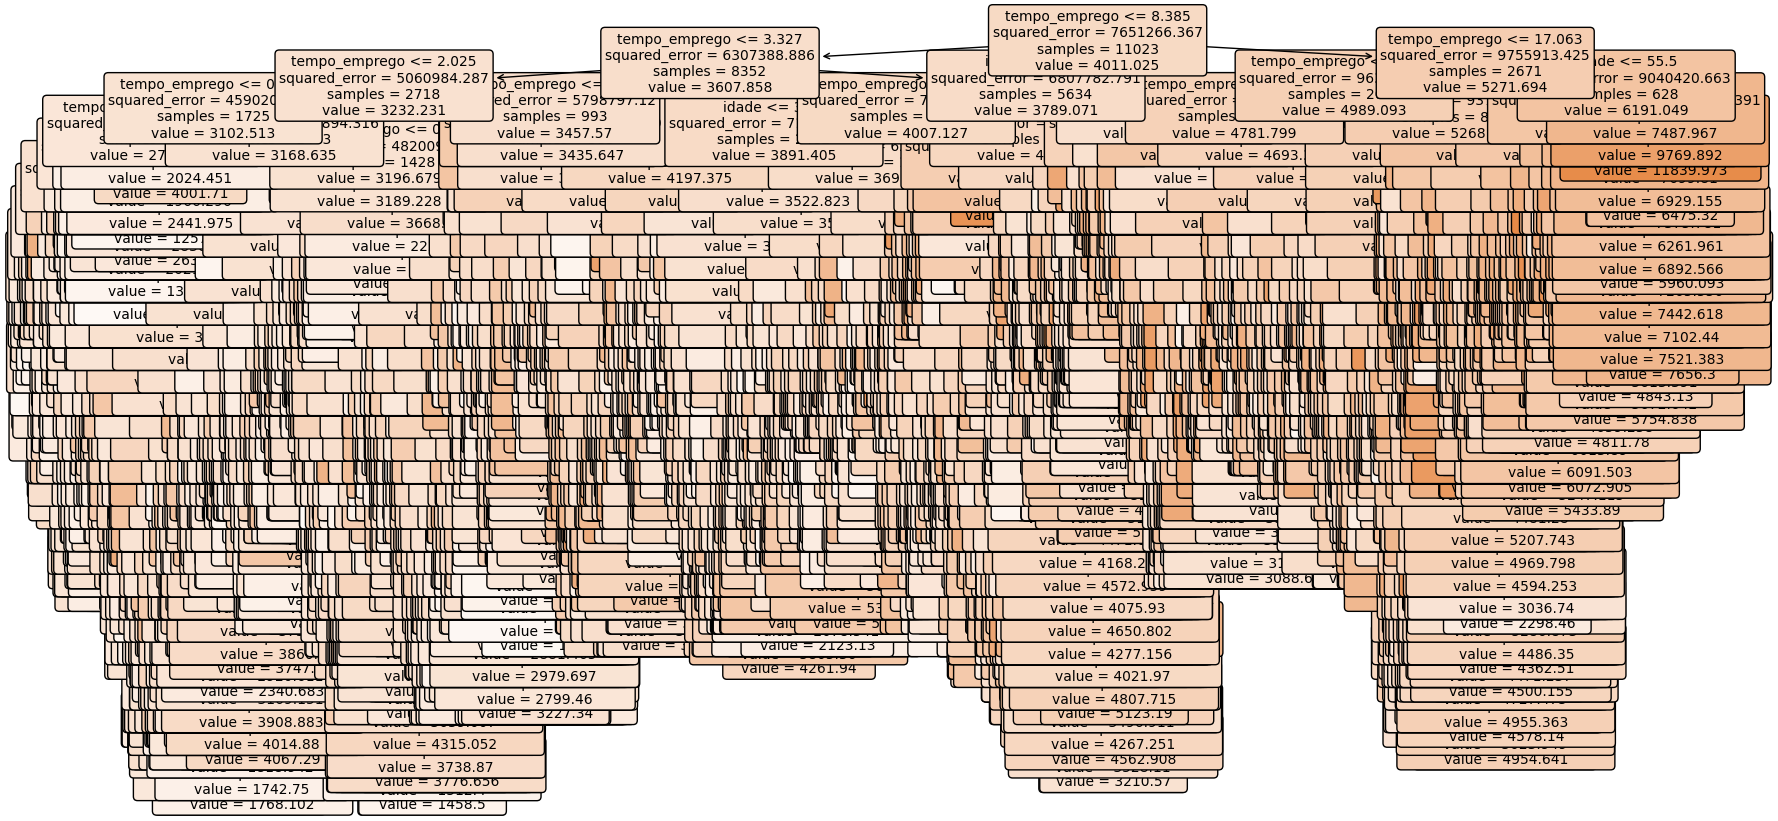

In [70]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(modelo_arvore, filled=True, feature_names=X_train.columns, rounded=True, fontsize=10)
plt.show()


# 8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é a mesma que a previsão média do log(renda).

In [71]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Faça previsões no conjunto de treinamento
previsoes_treino = modelo_ridge.predict(X_train_imputed)

# Calcule o logaritmo natural (ln) das previsões e das saídas reais
log_previsoes_treino = np.log(previsoes_treino)
log_y_treino = np.log(y_train)

# Calcule o erro RMSE nas previsões do conjunto de treinamento
rmse_treino = np.sqrt(mean_squared_error(log_y_treino, log_previsoes_treino))

# Exiba a previsão mediana e a média do log(renda) no conjunto de treinamento
mediana_treino = np.median(log_previsoes_treino)
media_treino = np.mean(log_previsoes_treino)

print(f'Conjunto de Treinamento - RMSE: {rmse_treino:.4f}')
print(f'Conjunto de Treinamento - Mediana do log(renda): {mediana_treino:.4f}')
print(f'Conjunto de Treinamento - Média do log(renda): {media_treino:.4f}')

# Faça previsões no conjunto de teste
previsoes_teste = modelo_ridge.predict(X_test_imputed)

# Calcule o logaritmo natural (ln) das previsões e das saídas reais
log_previsoes_teste = np.log(previsoes_teste)
log_y_teste = np.log(y_test)

# Calcule o erro RMSE nas previsões do conjunto de teste
rmse_teste = np.sqrt(mean_squared_error(log_y_teste, log_previsoes_teste))

# Exiba a previsão mediana e a média do log(renda) no conjunto de teste
mediana_teste = np.median(log_previsoes_teste)
media_teste = np.mean(log_previsoes_teste)

print('\nConjunto de Teste:')
print(f'RMSE: {rmse_teste:.4f}')
print(f'Mediana do log(renda): {mediana_teste:.4f}')
print(f'Média do log(renda): {media_teste:.4f}')


Conjunto de Treinamento - RMSE: 0.7333
Conjunto de Treinamento - Mediana do log(renda): 8.2440
Conjunto de Treinamento - Média do log(renda): 8.2790

Conjunto de Teste:
RMSE: 0.7391
Mediana do log(renda): 8.2413
Média do log(renda): 8.2794


# 9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.

In [72]:
# Calcula a previsão mediana da renda nos conjuntos de treinamento e teste
mediana_renda_treino = np.exp(mediana_treino)
mediana_renda_teste = np.exp(mediana_teste)

# Exibe a previsão mediana da renda nos conjuntos de treinamento e teste
print(f'Conjunto de Treinamento - Mediana da renda: {mediana_renda_treino:.2f}')
print(f'Conjunto de Teste - Mediana da renda: {mediana_renda_teste:.2f}')


Conjunto de Treinamento - Mediana da renda: 3804.79
Conjunto de Teste - Mediana da renda: 3794.59


# 10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico. Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.

   grupo       mean     median  <lambda_0>  <lambda_1>
0      0   6.476986   6.697800    4.930507    7.266369
1      1   7.894486   7.920810    7.432967    8.235321
2      2   8.612280   8.597026    8.344080    8.869533
3      3   9.130861   9.107165    8.935815    9.362300
4      4   9.700977   9.730409    9.412392    9.971551
5      5  10.253151  10.255073   10.048764   10.430020
6      6  10.732314  10.728178   10.493058   10.970229
7      7  11.315441  11.318240   11.024356   11.630924
8      8  11.995789  11.915829   11.673981   12.438981
9      9  13.601012  13.251771   12.625789   15.584668


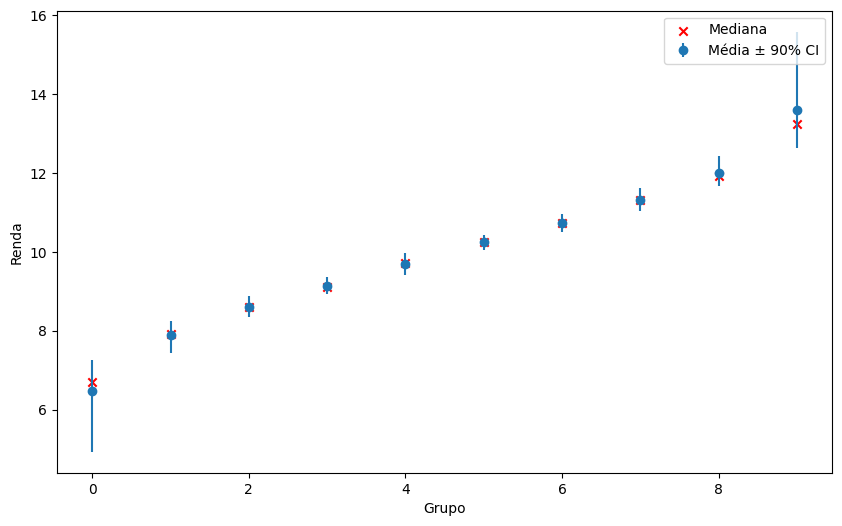

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exemplo hipotético (substitua pelos seus dados reais)
previsao_mediana_treino = np.random.normal(loc=10, scale=2, size=1000)  # substitua pelo seu array real
grupo = pd.qcut(previsao_mediana_treino, q=10, labels=False)

# Adiciona a previsão mediana da renda ao DataFrame original
df_resultados = pd.DataFrame({'previsao_mediana_treino': previsao_mediana_treino, 'grupo': grupo})

# Calcula média, mediana, percentil 5% e percentil 95% da renda para cada grupo
resultados_agrupados = df_resultados.groupby('grupo')['previsao_mediana_treino'].agg(['mean', 'median', lambda x: np.percentile(x, 5), lambda x: np.percentile(x, 95)]).reset_index()

# Exibe os resultados
print(resultados_agrupados)

# Cria um gráfico
plt.figure(figsize=(10, 6))
plt.errorbar(resultados_agrupados['grupo'], resultados_agrupados['mean'], yerr=[np.abs(resultados_agrupados['<lambda_0>'] - resultados_agrupados['mean']), np.abs(resultados_agrupados['<lambda_1>'] - resultados_agrupados['mean'])], fmt='o', label='Média ± 90% CI')
plt.scatter(resultados_agrupados['grupo'], resultados_agrupados['median'], marker='x', color='red', label='Mediana')
plt.xlabel('Grupo')
plt.ylabel('Renda')
plt.legend()
plt.show()


